# **Import required modules and classes**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage, misc
from scipy.ndimage import gaussian_filter
from skimage.feature import hog

import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import svm
import time
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA

import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

# **LOAD HODA DATASET**

**Load and Read the dataset** 

In [ ]:

with open('labels.pkl', 'rb') as lbs:
  labels = pickle.load(lbs)
  
# Convert the labels list into numpy array
labels = np.array(labels)

with open('images.pkl', 'rb') as imgs:
  images = pickle.load(imgs)

**Explore the dataset**

type(images):  <class 'list'>
len(images):  80000

type(labels):  <class 'numpy.ndarray'>
len(labels):  80000

----------------------------------------

type(images[ 0 ]): <class 'numpy.ndarray'>
images[ 0 ].dtype: uint8
images[ 0 ].min(): 0
images[ 0 ].max(): 255
images[ 0 ].shape = (HEIGHT, WIDTH): (27, 20)

type(labels[ 0 ]): <class 'numpy.int64'>
labels[ 0 ]: 6

----------------------------------------

type(images[ 1 ]): <class 'numpy.ndarray'>
images[ 1 ].dtype: uint8
images[ 1 ].min(): 0
images[ 1 ].max(): 255
images[ 1 ].shape = (HEIGHT, WIDTH): (20, 21)

type(labels[ 1 ]): <class 'numpy.int64'>
labels[ 1 ]: 5

----------------------------------------

type(images[ 2 ]): <class 'numpy.ndarray'>
images[ 2 ].dtype: uint8
images[ 2 ].min(): 0
images[ 2 ].max(): 255
images[ 2 ].shape = (HEIGHT, WIDTH): (10, 15)

type(labels[ 2 ]): <class 'numpy.int64'>
labels[ 2 ]: 0

----------------------------------------

type(images[ 3 ]): <class 'numpy.ndarray'>
images[ 3 ].dtype: uint8
image

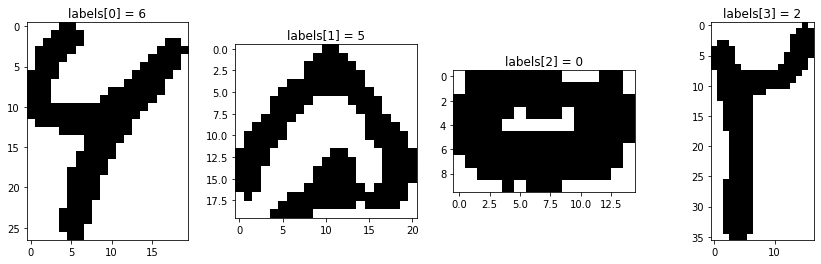

In [ ]:
print('type(images): ', type(images))
print('len(images): ', len(images))
print()

print('type(labels): ', type(labels))
print('len(labels): ', len(labels))
print()

# Show samples of the dataset

fig = plt.figure(figsize=(15, 4))

for i in range(4):

    print('----------------------------------------')
    print()

    print('type(images[', i, ']):', type(images[i]))
    print('images[', i, '].dtype:', images[i].dtype)
    print('images[', i, '].min():', images[i].min())
    print('images[', i, '].max():', images[i].max())
    print('images[', i, '].shape = (HEIGHT, WIDTH):', images[i].shape)
    print()

    print('type(labels[', i, ']):', type(labels[i]))
    print('labels[', i, ']:', labels[i])
    print()

    fig.add_subplot(1, 4, i + 1)
    plt.title('labels[' + str(i) + '] = ' + str(labels[i]))
    plt.imshow(images[i], cmap='gray')

plt.show()

# **Define Functions for preprocessing and Features extraction**

**Resize**

In [ ]:
def resizeImage(image):
    image = cv2.resize(image, (56,56))
    image = np.pad(image, pad_width=4,constant_values = 255)
    return image


**Sobel filter**

In [ ]:
def sobel(img):

   #horizontal mask
    hsobel_filter = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])/8.

    #Vertical mask

    vsobel_filter = np.array([[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1]])/8.

    img = np.array(img, dtype=np.float)
    if img.ndim != 2:
        raise ValueError('sobel: Only available for 2-dimensional images')

    max = img.max()
    img /= max
    
    vfiltered = ndimage.convolve(img, vsobel_filter, mode='reflect')
    hfiltered = ndimage.convolve(img, hsobel_filter, mode='reflect')
    vfiltered **= 2
    hfiltered **= 2
    filtered = vfiltered
    filtered += hfiltered
    return filtered

**DoG fillter**

In [ ]:
def dog(img , sigma1,sigma2 ):
    img = np.array(img, dtype=np.float)
    if img.ndim != 2:
        raise ValueError('DoG: Only available for 2-dimensional images')
    
    if sigma1 == None or  sigma2 == None:
        raise ValueError('Input the values of sigma1 and sigma2')
 
    G1 = gaussian_filter(img, sigma1, mode = 'nearest')
    G2 = gaussian_filter(img, sigma2, mode = 'nearest')
    DoG = G2 - G1
    
    return DoG



**Original HOG**

In [ ]:
def fd_hog(image):
  
    fv_hog = hog(image, orientations=3, pixels_per_cell=(16, 16),cells_per_block=(4,4),block_norm= 'L1-sqrt' ,transform_sqrt = False)

    return fv_hog

**Improved HOG**

In [ ]:
def fd_ihog(image):
    
    image = sobel(image)
    image = dog(image,0.949,3.84)  
    fv_ihog = hog(image, orientations=3, pixels_per_cell=(16, 16),cells_per_block=(4,4),block_norm= 'L1-sqrt' ,transform_sqrt = False)
    
    return fv_ihog

# **Features Extraction**

In [ ]:
feat_hog = [fd_hog(resizeImage(im)) for im in images]
feat_ihog= [fd_ihog(resizeImage(im)) for im in images]

# Original HOG features vector
feat_hog = np.array(feat_hog)

# Improved HOG features vector
feat_ihog=  np.array(feat_ihog)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


# **Visualisation**

**SOBEL+DoG**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


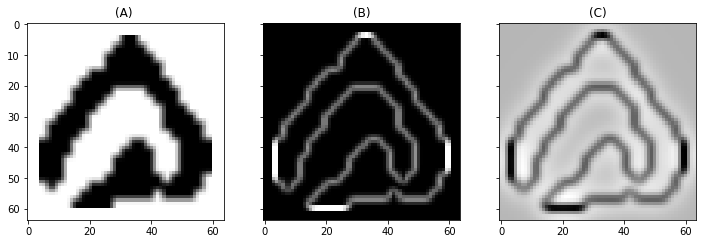

In [ ]:
image = images[1]
image = resizeImage(image)
s= sobel(image)
d = dog(s,0.949,3.84)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax1.axis('on')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('(A) ')


ax2.axis('on')
ax2.imshow(s, cmap=plt.cm.gray)
ax2.set_title('(B)')

ax3.axis('on')
ax3.imshow(d, cmap=plt.cm.gray)
ax3.set_title('(C)')
plt.savefig('digit_sobel_dog.png', dpi=300)
plt.show()


**Effect of HOG algorithm parameters**

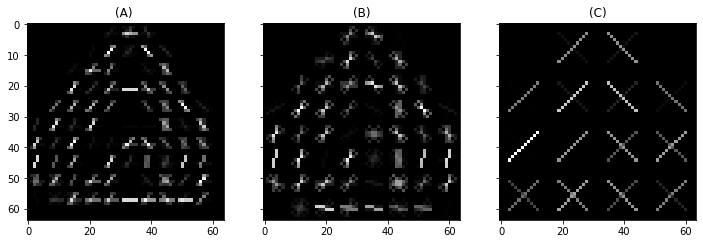

In [ ]:
image = images[1]
image = resizeImage(image)

fd1, hog_image1 = hog(image, orientations=5, pixels_per_cell=(6, 6),cells_per_block=(2,2),block_norm= 'L2' ,transform_sqrt = False,visualize=True)
fd2, hog_image2= hog(image, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(8,8),block_norm= 'L1-sqrt' ,transform_sqrt = False,visualize=True)
fd3, hog_image3= hog(image, orientations=2, pixels_per_cell=(16, 16),cells_per_block=(4,4),block_norm= 'L1-sqrt' ,transform_sqrt = False,visualize=True)



fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax1.axis('on')
ax1.imshow(hog_image1, cmap=plt.cm.gray)
ax1.set_title('(A) ')


ax2.axis('on')
ax2.imshow(hog_image2, cmap=plt.cm.gray)
ax2.set_title('(B)')

ax3.axis('on')
ax3.imshow(hog_image3, cmap=plt.cm.gray)
ax3.set_title('(C)')
plt.show()


**Comparison between detected features in Original HOG image and Improved HOG image**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


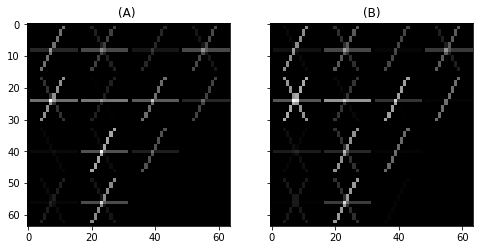

In [ ]:
image = images[0]
image = resizeImage(image)

fd1, hog_image1 = hog(image, orientations=3, pixels_per_cell=(16, 16),cells_per_block=(4,4),block_norm= 'L2' ,transform_sqrt = False,visualize=True)
image = sobel(image)
image = dog(image,0.55,3.2) 

fd2, hog_image2= hog(image, orientations=3, pixels_per_cell=(16,16),cells_per_block=(4,4),block_norm= 'L1-sqrt' ,transform_sqrt = False,visualize=True)





fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('on')
ax1.imshow(hog_image1, cmap=plt.cm.gray)
ax1.set_title('(A) ')


ax2.axis('on')
ax2.imshow(hog_image2, cmap=plt.cm.gray)
ax2.set_title('(B)')


plt.savefig('HOG_IHOG_1.png', dpi=300)
plt.show()


# *** Classification***

**Classification with Original HOG features**

In [ ]:
# Perform a training and testing split, using 
# 60,000 samples of training
# 20,000 for evaluation

################################################################################
################################################################################

(trainX, testX, trainY, testY) = train_test_split(feat_hog, labels,test_size=0.25,random_state=0,stratify = labels)
print("[INFO] The number of features ..." + str(feat_ihog.shape[1]))
print("[INFO] The number of training samples ..." + str(trainX.shape[0]))
print("[INFO] The number of training samples ..." + str(testX.shape[0]))

################################################################################
################################################################################


clf = svm.SVC(C= 5.403,kernel='rbf',gamma= 'scale' , decision_function_shape='ovr')

start_time = time.time()
model = clf.fit(trainX, trainY)
print("--- %s seconds ---" % (time.time() - start_time))

# make predictions on our data and show a classification report 5.403
print("[INFO] evaluating...")
predictions = model.predict(testX)
#print(testY,predictions3,le.classes_)


report = classification_report(testY, predictions,digits=4)

print(report)

acc = accuracy_score(testY, predictions)
print("Accuracy: %.4f%%" % (acc * 100.0))


[INFO] The number of features ...48
[INFO] The number of training samples ...60000
[INFO] The number of training samples ...20000
--- 13.108498573303223 seconds ---
[INFO] evaluating...
              precision    recall  f1-score   support

           0     0.9935    0.9920    0.9927      2000
           1     0.9970    0.9975    0.9973      2000
           2     0.9885    0.9915    0.9900      2000
           3     0.9935    0.9885    0.9910      2000
           4     0.9900    0.9940    0.9920      2000
           5     0.9930    0.9940    0.9935      2000
           6     0.9955    0.9900    0.9927      2000
           7     0.9970    0.9980    0.9975      2000
           8     1.0000    0.9995    0.9997      2000
           9     0.9935    0.9965    0.9950      2000

    accuracy                         0.9941     20000
   macro avg     0.9942    0.9941    0.9941     20000
weighted avg     0.9942    0.9941    0.9941     20000

Accuracy: 99.4150%


**Classification with Improved HOG features**

In [ ]:
# Perform a training and testing split, using 80000 samples of training
# using 20000 for evaluation

(trainX, testX, trainY, testY) = train_test_split(feat_ihog, labels,test_size=0.25,random_state=0,stratify = labels)

print("[INFO] The number of features ..." + str(feat_ihog.shape[1]))
print("[INFO] The number of training samples ..." + str(trainX.shape[0]))
print("[INFO] The number of training samples ..." + str(testX.shape[0]))

clf = svm.SVC(C= 5.403,kernel='rbf',gamma= 'scale' , decision_function_shape='ovr')

start_time = time.time()
model = clf.fit(trainX, trainY)
print("--- %s seconds ---" % (time.time() - start_time))

# make predictions on our data and show a classification report 5.403
print("[INFO] evaluating...")
predictions = model.predict(testX)
#print(testY,predictions3,le.classes_)


report = classification_report(testY, predictions,digits=4)

print(report)

acc = accuracy_score(testY, predictions)
print("Accuracy: %.4f%%" % (acc * 100.0))


[INFO] The number of features ...48
[INFO] The number of training samples ...60000
[INFO] The number of training samples ...20000
--- 8.019634485244751 seconds ---
[INFO] evaluating...
              precision    recall  f1-score   support

           0     0.9975    0.9975    0.9975      2000
           1     0.9980    0.9985    0.9983      2000
           2     0.9906    0.9960    0.9933      2000
           3     0.9965    0.9905    0.9935      2000
           4     0.9950    0.9975    0.9963      2000
           5     0.9985    0.9975    0.9980      2000
           6     0.9975    0.9950    0.9962      2000
           7     0.9980    0.9990    0.9985      2000
           8     0.9995    0.9995    0.9995      2000
           9     0.9965    0.9965    0.9965      2000

    accuracy                         0.9968     20000
   macro avg     0.9968    0.9967    0.9967     20000
weighted avg     0.9968    0.9968    0.9967     20000

Accuracy: 99.6750%


# **Dimensionality reduction**

In [ ]:

def dim_redu(f_train_hog,f_test_hog,train_labels,test_labels):

    # Initialise a list of accuracies, number of  features, training time and testing time for each dimension 
    # of features vector
    accuracy = []
    cp = []
    train_time = []
    test_time = []
    gm = []
    trainY = train_labels
    testY = test_labels


    clf = svm.SVC(C= 5.3284,kernel='rbf',gamma=5.932 , decision_function_shape='ovr')

    ncompo = list(range(1,49,1))
    for nc in ncompo:

        pca = PCA(n_components=nc)
        pc = pca.fit(f_train_hog)
        trainX = pc.transform(f_train_hog)
        testX = pc.transform(f_test_hog)
        start_train_time = time.time()
        print('##### [INFO] Started the classification the number of  ' + str(nc)+ ' features #####')
        model = clf.fit(trainX, trainY)
        gmm  = model._gamma
        trt = time.time() - start_train_time

        start_test_time = time.time()

        predictions = model.predict(testX)
        tst = time.time() - start_test_time

        acc = accuracy_score(testY, predictions)

        train_time.append(trt)
        test_time.append(tst)
        accuracy.append(acc* 100)
        cp.append(nc)
        gm.append(gmm)
        print("Accuracy: %.4f%%" % (acc * 100.0))
        print('##### [INFO] Finishied the classification the number of  ' + str(nc)+ 'features #####')
      
    return accuracy, cp, train_time, test_time,gm



**Dimension reduction for original HOG**

In [ ]:

def dim_redu(f_train_hog,f_test_hog,train_labels,test_labels):

    # Initialise a list of accuracies, number of  features, training time and testing time for each dimension 
    # of features vector

    ########################################################################################################
    ########################################################################################################

    accuracy = []
    cp = []
    train_time = []
    test_time = []

    ########################################################################################################
    ########################################################################################################

    trainY = train_labels
    testY = test_labels


    clf = svm.SVC(C= 5.3284,kernel='rbf',gamma=5.932 , decision_function_shape='ovr')

    ncompo = list(range(1,49,1))
    for nc in ncompo:

        pca = PCA(n_components=nc)
        pc = pca.fit(f_train_hog)
        trainX = pc.transform(f_train_hog)
        testX = pc.transform(f_test_hog)
        start_train_time = time.time()
        print('##### [INFO] Started the classification the number of  ' + str(nc)+ ' features #####')
        model = clf.fit(trainX, trainY)
        gmm  = model._gamma
        trt = time.time() - start_train_time

        start_test_time = time.time()

        predictions = model.predict(testX)
        tst = time.time() - start_test_time

        acc = accuracy_score(testY, predictions)

        train_time.append(trt)
        test_time.append(tst)
        accuracy.append(acc* 100)
        cp.append(nc)
        print("Accuracy: %.4f%%" % (acc * 100.0))
        print('##### [INFO] Finishied the classification the number of  ' + str(nc)+ 'features #####')
      
    return accuracy, cp, train_time, test_time


########################################################################################################
########################################################################################################


(trainX, testX, trainY, testY) = train_test_split(feat_hog, labels,test_size=0.25,random_state=0,stratify = labels)
accuracy1, cp1, train_time1, test_time1 = dim_redu(trainX,testX,trainY,testY)



##### [INFO] Started the classification the number of  1 features #####
Accuracy: 43.7550%
##### [INFO] Finishied the classification the number of  1features #####
##### [INFO] Started the classification the number of  2 features #####
Accuracy: 61.6250%
##### [INFO] Finishied the classification the number of  2features #####
##### [INFO] Started the classification the number of  3 features #####
Accuracy: 76.4050%
##### [INFO] Finishied the classification the number of  3features #####
##### [INFO] Started the classification the number of  4 features #####
Accuracy: 85.9450%
##### [INFO] Finishied the classification the number of  4features #####
##### [INFO] Started the classification the number of  5 features #####
Accuracy: 91.1300%
##### [INFO] Finishied the classification the number of  5features #####
##### [INFO] Started the classification the number of  6 features #####
Accuracy: 94.9100%
##### [INFO] Finishied the classification the number of  6features #####
##### [INFO] Sta

In [ ]:
df1 = pd.DataFrame(list(zip(cp1, accuracy1,train_time1,test_time1)), columns =['number of components', 'Accuracy','Train time', 'Test time']) 
compression_opts = dict(method='zip', archive_name='HOG_48.csv')  
df1.to_csv('HOG_48.zip', index=False,   compression=compression_opts)

**Demo**


unoptimised SVM

In [ ]:
# Perform a training and testing split, using 80000 samples of training
# using 20000 for evaluation

(trainX, testX, trainY, testY) = train_test_split(feat_hog, labels,test_size=0.25,random_state=0,stratify = labels)

print("[INFO] The original number of features ..." + str(trainX.shape[1]))

pca = PCA(n_components = 47)
pc = pca.fit(trainX)
trainX = pc.transform(trainX)
testX = pc.transform(testX)

print("[INFO] The number of features after selection ..." + str(trainX.shape[1]))


clf = svm.SVC(C= 5.403,kernel='rbf',gamma= 'scale' , decision_function_shape='ovr')

start_time = time.time()
model = clf.fit(trainX, trainY)
print("--- %s seconds ---" % (time.time() - start_time))

# make predictions on our data and show a classification report 5.403
print("[INFO] evaluating...")
predictions = model.predict(testX)
#print(testY,predictions3,le.classes_)


report = classification_report(testY, predictions,digits=4)

print(report)

acc = accuracy_score(testY, predictions)
print("Accuracy: %.4f%%" % (acc * 100.0))


[INFO] The original number of features ...48
[INFO] The number of features after selection ...47
--- 13.68920636177063 seconds ---
[INFO] evaluating...
              precision    recall  f1-score   support

           0     0.9930    0.9915    0.9922      2000
           1     0.9975    0.9975    0.9975      2000
           2     0.9900    0.9915    0.9908      2000
           3     0.9930    0.9890    0.9910      2000
           4     0.9900    0.9945    0.9923      2000
           5     0.9925    0.9935    0.9930      2000
           6     0.9955    0.9915    0.9935      2000
           7     0.9975    0.9980    0.9978      2000
           8     1.0000    0.9995    0.9997      2000
           9     0.9940    0.9965    0.9953      2000

    accuracy                         0.9943     20000
   macro avg     0.9943    0.9943    0.9943     20000
weighted avg     0.9943    0.9943    0.9943     20000

Accuracy: 99.4300%


Optimised SVM (Table 4 in the paper)

In [ ]:
# Perform a training and testing split, using 80000 samples of training
# using 20000 for evaluation

(trainX, testX, trainY, testY) = train_test_split(feat_hog, labels,test_size=0.25,random_state=0,stratify = labels)

print("[INFO] The original number of features ..." + str(trainX.shape[1]))

pca = PCA(n_components = 47)
pc = pca.fit(trainX)
trainX = pc.transform(trainX)
testX = pc.transform(testX)

print("[INFO] The number of features after selection ..." + str(trainX.shape[1]))


clf = svm.SVC(C= 5.3284,kernel='rbf',gamma=5.932 , decision_function_shape='ovr')

start_time = time.time()
model = clf.fit(trainX, trainY)
print("--- %s seconds ---" % (time.time() - start_time))

# make predictions on our data and show a classification report 5.403
print("[INFO] evaluating...")
predictions = model.predict(testX)
#print(testY,predictions3,le.classes_)


report = classification_report(testY, predictions,digits=4)

print(report)

acc = accuracy_score(testY, predictions)
print("Accuracy: %.4f%%" % (acc * 100.0))


[INFO] The original number of features ...48
[INFO] The number of features after selection ...47
--- 28.304203510284424 seconds ---
[INFO] evaluating...
              precision    recall  f1-score   support

           0     0.9920    0.9920    0.9920      2000
           1     0.9975    0.9965    0.9970      2000
           2     0.9915    0.9915    0.9915      2000
           3     0.9935    0.9910    0.9922      2000
           4     0.9925    0.9965    0.9945      2000
           5     0.9935    0.9935    0.9935      2000
           6     0.9955    0.9930    0.9942      2000
           7     0.9980    0.9980    0.9980      2000
           8     1.0000    1.0000    1.0000      2000
           9     0.9945    0.9965    0.9955      2000

    accuracy                         0.9949     20000
   macro avg     0.9949    0.9948    0.9948     20000
weighted avg     0.9949    0.9949    0.9948     20000

Accuracy: 99.4850%


**Dimension reduction for Improved HOG features**

In [ ]:

def dim_redu(f_train_hog,f_test_hog,train_labels,test_labels):

    # Initialise a list of accuracies, number of  features, training time and testing time for each dimension 
    # of features vector
    #################################################################################################
    #################################################################################################

    accuracy = []
    cp = []
    train_time = []
    test_time = []

    #################################################################################################
    #################################################################################################

    trainY = train_labels
    testY = test_labels


    clf = svm.SVC(C= 6.06,kernel='rbf',gamma=2.865 , decision_function_shape='ovr')
    ncompo = list(range(1,49,1))
    for nc in ncompo:

        pca = PCA(n_components=nc)
        pc = pca.fit(f_train_hog)
        trainX = pc.transform(f_train_hog)
        testX = pc.transform(f_test_hog)
        start_train_time = time.time()
        print('##### [INFO] Started the classification the number of  ' + str(nc)+ ' features #####')
        model = clf.fit(trainX, trainY)
        gmm  = model._gamma
        trt = time.time() - start_train_time

        start_test_time = time.time()

        predictions = model.predict(testX)
        tst = time.time() - start_test_time

        acc = accuracy_score(testY, predictions)

        train_time.append(trt)
        test_time.append(tst)
        accuracy.append(acc* 100)
        cp.append(nc)
        print("Accuracy: %.4f%%" % (acc * 100.0))
        print('##### [INFO] Finishied the classification the number of  ' + str(nc)+ 'features #####')
      
    return accuracy, cp, train_time, test_time



########################################################################################################
########################################################################################################

(trainX, testX, trainY, testY) = train_test_split(feat_ihog, labels,test_size=0.25,random_state=0,stratify = labels)

accuracy2, cp2, train_time2, test_time2 = dim_redu(trainX,testX,trainY,testY)


##### [INFO] Started the classification the number of  1 features #####
Accuracy: 48.4950%
##### [INFO] Finishied the classification the number of  1features #####
##### [INFO] Started the classification the number of  2 features #####
Accuracy: 65.0250%
##### [INFO] Finishied the classification the number of  2features #####
##### [INFO] Started the classification the number of  3 features #####
Accuracy: 81.0250%
##### [INFO] Finishied the classification the number of  3features #####
##### [INFO] Started the classification the number of  4 features #####
Accuracy: 88.2700%
##### [INFO] Finishied the classification the number of  4features #####
##### [INFO] Started the classification the number of  5 features #####
Accuracy: 93.2300%
##### [INFO] Finishied the classification the number of  5features #####
##### [INFO] Started the classification the number of  6 features #####
Accuracy: 95.4450%
##### [INFO] Finishied the classification the number of  6features #####
##### [INFO] Sta

ValueError: ignored

In [ ]:
df2 = pd.DataFrame(list(zip(cp2, accuracy2,train_time2,test_time2)), columns =['number of components', 'Accuracy','Train time', 'Test time']) 
compression_opts = dict(method='zip', archive_name='IHOG_48.csv')  
df2.to_csv('IHOG_48.zip', index=False,   compression=compression_opts)

In [ ]:
print("[INFO] The max accuracy ..." + str(max(accuracy2)))

npc2 = feat_selec(accuracy2)

print("[INFO] The first principal components correpend to max accuracy ..." + str(npc2))

[INFO] The max accuracy ...99.68
[INFO] The first principal components correpend to max accuracy ...47


unoptimised SVM

In [ ]:
# Perform a training and testing split, using 80000 samples of training
# using 20000 for evaluation

(trainX, testX, trainY, testY) = train_test_split(feat_ihog, labels,test_size=0.25,random_state=0,stratify = labels)

print("[INFO] The original number of features ..." + str(trainX.shape[1]))

pca = PCA(n_components = 47)
pc = pca.fit(trainX)
trainX = pc.transform(trainX)
testX = pc.transform(testX)

print("[INFO] The number of features after selection ..." + str(trainX.shape[1]))


clf = svm.SVC(C= 5.403,kernel='rbf',gamma= 'scale' , decision_function_shape='ovr')

start_time = time.time()
model = clf.fit(trainX, trainY)
print("--- %s seconds ---" % (time.time() - start_time))

# make predictions on our data and show a classification report 5.403
print("[INFO] evaluating...")
predictions = model.predict(testX)
#print(testY,predictions3,le.classes_)


report = classification_report(testY, predictions,digits=4)

print(report)

acc = accuracy_score(testY, predictions)
print("Accuracy: %.4f%%" % (acc * 100.0))


[INFO] The original number of features ...48
[INFO] The number of features after selection ...47
--- 11.10674500465393 seconds ---
[INFO] evaluating...
              precision    recall  f1-score   support

           0     0.9975    0.9975    0.9975      2000
           1     0.9980    0.9980    0.9980      2000
           2     0.9906    0.9960    0.9933      2000
           3     0.9965    0.9905    0.9935      2000
           4     0.9950    0.9975    0.9963      2000
           5     0.9985    0.9975    0.9980      2000
           6     0.9975    0.9945    0.9960      2000
           7     0.9980    0.9990    0.9985      2000
           8     1.0000    0.9995    0.9997      2000
           9     0.9955    0.9970    0.9963      2000

    accuracy                         0.9967     20000
   macro avg     0.9967    0.9967    0.9967     20000
weighted avg     0.9967    0.9967    0.9967     20000

Accuracy: 99.6700%


In [ ]:
# Perform a training and testing split, using 80000 samples of training
# using 20000 for evaluation

(trainX, testX, trainY, testY) = train_test_split(feat_ihog, labels,test_size=0.25,random_state=0,stratify = labels)

print("[INFO] The original number of features ..." + str(trainX.shape[1]))

pca = PCA(n_components = 47)
pc = pca.fit(trainX)
trainX = pc.transform(trainX)
testX = pc.transform(testX)

print("[INFO] The number of features after selection ..." + str(trainX.shape[1]))

clf = svm.SVC(C= 6.06,kernel='rbf',gamma=2.865 , decision_function_shape='ovr')

start_time = time.time()
model = clf.fit(trainX, trainY)
print("--- %s seconds ---" % (time.time() - start_time))

# make predictions on our data and show a classification report 5.403
print("[INFO] evaluating...")
predictions = model.predict(testX)
#print(testY,predictions3,le.classes_)


report = classification_report(testY, predictions,digits=4)

print(report)

acc = accuracy_score(testY, predictions)
print("Accuracy: %.4f%%" % (acc * 100.0))


[INFO] The original number of features ...48
[INFO] The number of features after selection ...47
--- 14.153786420822144 seconds ---
[INFO] evaluating...
              precision    recall  f1-score   support

           0     0.9975    0.9975    0.9975      2000
           1     0.9980    0.9980    0.9980      2000
           2     0.9906    0.9960    0.9933      2000
           3     0.9965    0.9905    0.9935      2000
           4     0.9950    0.9975    0.9963      2000
           5     0.9985    0.9975    0.9980      2000
           6     0.9980    0.9950    0.9965      2000
           7     0.9980    0.9990    0.9985      2000
           8     1.0000    0.9995    0.9997      2000
           9     0.9960    0.9975    0.9968      2000

    accuracy                         0.9968     20000
   macro avg     0.9968    0.9968    0.9968     20000
weighted avg     0.9968    0.9968    0.9968     20000

Accuracy: 99.6800%


**Plot accuracy versus the number of components**

In [ ]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(mode = "lines+markers",x=cp1[19:], y=np.array(accuracy1[19:]) , name="Original HOG-PCA"),)
fig1.add_trace(go.Scatter(mode = "lines+markers",x=cp1[19:], y=np.array(accuracy2[19:]) , name="Improved HOG-PCA"),)

# Set x-axis title
fig1.update_xaxes(title_text="Number of components")
fig1.update_traces(textfont_family ="Times New Roman")

# Set y-axes titles
fig1.update_yaxes(title_text="Accuracy(%)")
fig1.update_traces(textfont_family ="Times New Roman")

fig1.update_layout(margin=dict(l=20, r=20, t=20, b=20),
    title="(A)"
,title_font_size=15,autosize=False,
    width=900,
    height=300)

fig1.show()